# Homework 7
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem

Using SDSS SkyServer/CasJobs to query and download subsets of data sets.

Log on to SDSS CasJobs interface by following the link for 'CasJobs' that appear once you're logged into SkyServer, at http://skyserver.sdss.org. Then:

1. Write a query that selects Galactic latitude and longitude, and the "de-reddened" $g$ and $r$ band magnitudes of stars (from table `Star`) in a 1-degree radius circle around two directions in the sky:

$$ {\rm Field\, A}: \alpha = 341.6^\circ, \delta = 31.7^\circ $$
$$ {\rm Field\, B}: \alpha = 115.2^\circ, \delta = 32.7^\circ $$

Consult the [Schema Browser](https://skyserver.sdss.org/CasJobs/SchemaBrowser.aspx) to find the apropriate column names. Have the query store these into two MyDB tables, `fieldA` and `fieldB`.

2. Download these tables as CSV (comma separated value) files.

3. Use Python APIs of your choice (e.g., `numpy`, `Pandas`, or some other) to load these files in a Python notebook. Note that functions for loading CSV data already exist in nearly all of these APIs; don't write your own parser!

4. Make a side-by-side $(ra, dec)$ plot for the two fields, to show the selected data truly spans only a 2-degree diameter circle.

5. Make side-by-side color-magnitude diagrams (CMDs), with $g-r$ on the `x` axis, and $g$ on the `y` axis. Set the plot limits to show only values $-0.5 < g-r < 2$ and $14 < g < 22$ (note: use the "astronomer's convention" for the $y$ axis, i.e., flip it). The diagrams could either be scatter or density plots; choose what you feel is best to bring out any interesting features and/or differences.

6. Comment on any similarities and differences you find in the plots created above.

In [1]:
print """
fieldA Query:
SELECT
  s.objID,s.b,s.l,s.dered_g,s.dered_r into mydb.MyTable from Star AS s,
  dbo.fGetNearbyObjEq(341.6,31.7,60) AS r
WHERE
  r.objID = s.objID



fieldB Query:
SELECT
  s.objID,s.b,s.l,s.dered_g,s.dered_r into mydb.MyTable from Star AS s,
  dbo.fGetNearbyObjEq(115.2,32.7,60) AS r
WHERE
  r.objID = s.objID
"""


fieldA Query:
SELECT
  s.objID,s.b,s.l,s.dered_g,s.dered_r into mydb.MyTable from Star AS s,
  dbo.fGetNearbyObjEq(341.6,31.7,60) AS r
WHERE
  r.objID = s.objID



fieldB Query:
SELECT
  s.objID,s.b,s.l,s.dered_g,s.dered_r into mydb.MyTable from Star AS s,
  dbo.fGetNearbyObjEq(115.2,32.7,60) AS r
WHERE
  r.objID = s.objID



In [2]:
import numpy as np
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
% matplotlib inline

# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [3]:
import os
try:
    os.remove("HW7.db")
except OSError:
    pass

In [4]:
# Create connection to HW7.db that contains fieldA and fieldB
con = sqlite3.connect("HW7.db")

In [5]:
# Create the table within fieldA
con.execute("""
CREATE TABLE fieldA (
	objID	bigint,
	b	float,
	l	float,
	dered_g	real,
	dered_r	real
);
""")

In [6]:
# Create the table within fieldB
con.execute("""
CREATE TABLE fieldB (
	objID	bigint,
	b	float,
	l	float,
	dered_g	real,
	dered_r	real
);
""")

In [7]:
# Read in fieldA csv
fieldA = pd.read_csv('fieldA.csv', index_col=['objID','b','l','dered_g','dered_r'])

In [8]:
# Read in fieldB csv
fieldB = pd.read_csv('fieldB.csv', index_col=['objID','b','l','dered_g','dered_r'])

In [9]:
# Change fieldA to SQL
fieldA.to_sql('fieldA', con, if_exists='append')

In [10]:
# Change fieldB to SQL
fieldB.to_sql('fieldB', con, if_exists='append')

In [11]:
# Write fieldA to a dataframe
resultA = pd.read_sql("""
    SELECT
        fieldA.objID, fieldA.b, fieldA.l, fieldA.dered_g, fieldA.dered_r
    FROM
        fieldA
""", con)

In [12]:
# Write fieldB to a dataframe
resultB = pd.read_sql("""
    SELECT
        fieldB.objID, fieldB.b, fieldB.l, fieldB.dered_g, fieldB.dered_r
    FROM
        fieldB
""", con)

In [13]:
def plot_stars(result):
    """
    plot_stars plots the objects by their galactic lattitude/longitude
    Input:
        -result: Table containing object galactic lattitude and longitude
    Output:
        -Plot of the field of objects
    """
    
    galLat = result['b']
    galLong = result['l']
    print "Diameter:", ((max(galLong)-min(galLong))+(max(galLat)-min(galLat)))/2
    
    
    fig, ax = plt.subplots(figsize=(8, 3.75))
    plt.plot(galLong,galLat,'g*')
    ax.set_xlabel("Galactic Longitude")
    ax.set_xlim(min(galLong)-2.5,max(galLong)+2.5)
    ax.set_ylabel("Galactic Latitude")
    ax.set_ylim(min(galLat)-0.5,max(galLat)+0.5)
    ax.set_title("Field Scatter")
    ax.grid(True)
    
    plt.show()

Diameter: 2.09392304628


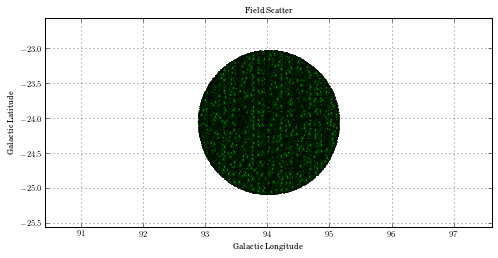

In [14]:
plot_stars(resultA)

Diameter: 2.09291129695


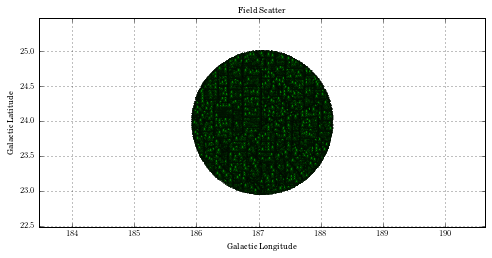

In [15]:
plot_stars(resultB)

In [16]:
def CMD(result1,result2):
    """
    CMD plots the color magniude diagrams for multiple fields of view.  Plotting g vs. g-r.
    Input:
        -result1: A table containing dered green and red magnitudes for each object.
        -result1: A table containing dered green and red magnitudes for each object.
    Output:
        -Plots g vs. g-r for two fields of view.
    """
    
    g_r1 = result1['dered_g'] - result1['dered_r']
    g1 = result1['dered_g']
    g_r2 = result2['dered_g'] - result2['dered_r']
    g2 = result2['dered_g']
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(211)  
    ax.scatter(g_r1,g1,s=0.05,c='black')
    plt.ylabel('g')
    plt.ylim(22,14)
    plt.xlabel('g-r')
    plt.xlim(-0.5,2)
    plt.title('Color Magnitude Diagram fieldA')
    plt.plot()
    
    ax = fig.add_subplot(212) 
    ax.scatter(g_r2,g2,s=0.05,c='black')
    plt.ylabel('g')
    plt.ylim(22,14)
    plt.xlabel('g-r')
    plt.xlim(-0.5,2)
    plt.title('Color Magnitude Diagram fieldB')
    plt.plot()
    
    plt.show()

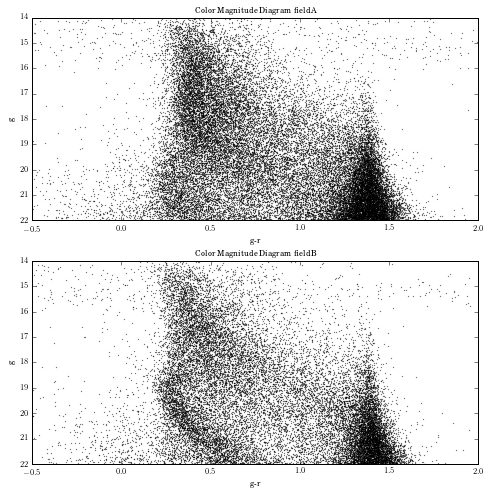

In [17]:
CMD(resultA, resultB)

In [18]:
print """
Similarities:
-Strong Grouping centered at g-r of 1.4
-Concentrated Scatter between g-r 0.3 and 1.3
-Gaps at g-r > 1.5, g-r <0.2 and 16<g<20

Differences:
-fieldA's peak at g-r of 1.4 is more concentrated than fieldB's.
-fieldA has more concentration around g-r = 0.4 and 15<g<19 than fieldB.
-fieldB has a strong diagonal cluster between 0.3<g-r<0.7 and 18<g<22.  
Not seen in fieldA
"""


Similarities:
-Strong Grouping centered at g-r of 1.4
-Concentrated Scatter between g-r 0.3 and 1.3
-Gaps at g-r > 1.5, g-r <0.2 and 16<g<20

Differences:
-fieldA's peak at g-r of 1.4 is more concentrated than fieldB's.
-fieldA has more concentration around g-r = 0.4 and 15<g<19 than fieldB.
-fieldB has a strong diagonal cluster between 0.3<g-r<0.7 and 18<g<22.  
Not seen in fieldA

